In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sklearn

In [2]:
device = torch.device("cuda")
device = torch.device("cpu")

# Parameters

In [3]:
# PARAMETERS FOR DATA MODEL    
nc = 3 
nw = 1200 
L = 15 
K = 1000 
word_freq = 'uniform'

# PARAMETERS FOR NEURAL NETWORK ARCHITECTURE
layer_norm = False
d = 100 

# PARAMETERS FOR TRAINING
nspl = 5
weight_decay_W = 0.001   
weight_decay_U = 0.001 
lr = 0.1 
bsz = 100 
num_epochs = 1200

# Data Model

In [4]:
class DataModel:
    
    def __init__(self, nc, nw, L, K, word_freq = 'uniform'):
        """
        INPUT: nc, nw, L and K are the number of concepts, the number of words, the length
               of the sentences, and the number of classes, respectively. 
               word_freq must be be either 'uniform' or 'zipf'
        
        ATTRIBUTES: Z is a LongTensor of shape (K,L) that contains the K latent variables. That is:
                                  Z[k] = k-th latent variable
                    These K latent variables are selected uniformly at random in the latent space.
                    
                    mu is a FloatTensor of shape (sc,) that contains the word frequencies. That is:
                                  mu[beta] = frequency of word beta-th word of each concept
        """
        
        # select the latent variables uniformly at random in the latent space
        self.Z = torch.randint(0, nc, size=(K,L) )
    
        # Define word frequencies mu_1, ... mu_sc (either uniform or Zipf distribution)
        sc = nw // nc
        if word_freq == 'zipf': 
            ii = torch.arange(1,sc+1)
            mu = 1 / ii
            mu = mu / mu.sum()
        elif word_freq == 'uniform':
            mu = 1/sc * torch.ones(sc)
            
        self.L = L    
        self.K = K
        self.mu = mu
        
    def sample(self,nspl):
        """
        Generate N = K*nspl sentences 
        Each latent variable generate nspl sentences
        Sentences generated by the k-th latent variable are assigned label k
        
        OUTPUT:
        Alpha: LongTensor of shape (N,L) whose entries belong to {0,1,...,nc-1}
        Beta: Longtensor of shape (N,L) whose entries belong to {0,1,...,sc-1}
        label:  Longtensor of shape (N,) whose entries belong to {0,1,...,K}  
        
        
        Recall that a sentence is a sequence of L words, and that it takes the form
        
        x = [(alpha_1,beta_1) , (alpha_2,beta_2) , ... , (alpha_L,beta_L)]
        
        This functions generates N = K*nspl sentences. Its outputs are:
        
        
        The i-th data points is:
        
        [ (Alpha[i,1] , Beta[i,1]) , (Alpha[i,2] , Beta[i,2])  , ... , (Alpha[i,L] , Beta[i,L]) ]
        
        and it has label label[i]
        """
        
        distribution = torch.distributions.categorical.Categorical(self.mu)
        
        Alpha = self.Z.repeat_interleave(nspl,dim=0)
        Beta =  distribution.sample( sample_shape = ( self.K*nspl , self.L)  )
        labels =  torch.arange(K).repeat_interleave(nspl,dim=0) 
        
        return Alpha, Beta, labels       

In [5]:
datamodel = DataModel(nc, nw, L, K, word_freq)
Alpha, Beta, label = datamodel.sample(nspl) #create the training set
test_Alpha, test_Beta, test_label = datamodel.sample(5) #create the test set

# Examples

### the tuple $(\alpha,\beta)$ denote the $\beta$-th word of the $\alpha$-th concept. It  has a probability $\mu_\beta$ of being sampled. 

### Each latent variable is a sequence of $L$ concept
### $$
{\bf z} = [\alpha_1, \alpha_2, \ldots, \alpha_L] \qquad \text{where } \alpha_\ell \in [n_c]
$$
### and it generates data points of the form
### $${\bf x} = [\;(\alpha_1,\beta_1),\; (\alpha_2, \beta_2),\, \ldots,\; (\alpha_L,\beta_L)\;]  \qquad \text{where } \alpha_\ell \in [n_c] \text{ and } \beta_\ell \in [s_c] 
$$

Here is the first latent variable (we have nc=3 concepts and L=15):

tensor([2, 2, 1, 0, 2, 1, 0, 0, 1, 2, 1, 0, 1, 1, 1])

Here is one sentence from the training set that was generated by the above latent variable
(each of the 3 concepts contains 400 words)

[(2, 308), (2, 272), (1, 130), (0, 381), (2, 289), (1, 91), (0, 255), (0, 249), (1, 289), (2, 241), (1, 243), (0, 115), (1, 250), (1, 388), (1, 378)]

Here is another one:

[(2, 251), (2, 177), (1, 251), (0, 287), (2, 54), (1, 91), (0, 118), (0, 159), (1, 222), (2, 207), (1, 376), (0, 245), (1, 6), (1, 323), (1, 278)]

Finally, here is a plot of the word frequencies mu_beta:



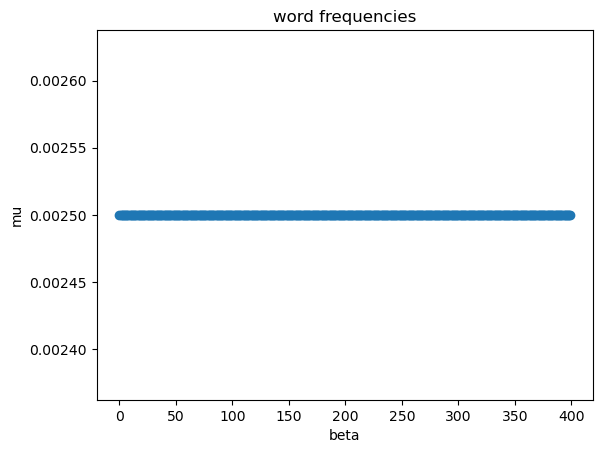

In [6]:
print('Here is the first latent variable (we have nc=3 concepts and L=15):\n')
print(datamodel.Z[0])

print('\nHere is one sentence from the training set that was generated by the above latent variable')
print('(each of the 3 concepts contains 400 words)\n')
print(  [ (Alpha[0,ell].item(), Beta[0,ell].item()) for ell in range(L) ] )

print('\nHere is another one:\n')
print(  [ (Alpha[1,ell].item(), Beta[1,ell].item()) for ell in range(L) ] )

print('\nFinally, here is a plot of the word frequencies mu_beta:\n')
plt.plot(datamodel.mu,'o')
plt.title('word frequencies')
plt.xlabel('beta')
plt.ylabel('mu')
plt.show()

# One-hot encoding of the words
### Each word has the format $(\alpha,\beta)$ where $0 \le \alpha \le n_c-1$ and $0 \le \beta \le s_c-1$. In order to use the pytorch embedding module, we need to replace this double index by a single index. So we simply do
### $$(\alpha,\beta) \mapsto  \alpha s_c + \beta $$ 
### We then put the train set into a tensor train_data of shape $(N , L)$ and with entries in $\{0,1, \ldots , n_w-1\}$, where $N=Kn_{spl}$ is the total number of training points.  

In [7]:
sc = nw // nc
train_data = sc*Alpha + Beta
train_label = label

### Same for the test set

In [8]:
test_data = sc * test_Alpha + test_Beta

# Neural Network

In [9]:
class SimpleNet(nn.Module):
    
    def __init__(self, nw, L, d, K, layer_norm=True):
        super().__init__()
        
        self.emb  = nn.Embedding(nw,d)
        if layer_norm:
            self.lnorm = nn.LayerNorm(d, elementwise_affine=False)
        self.clf  = nn.Linear(L*d, K, bias=False) 
        
        # Initializing the weights to be close to zero makes the training easier  
        self.emb.weight.data = self.emb.weight.data / 1000
        self.clf.weight.data = self.clf.weight.data / 1000
        
        self.L = L
        self.d = d
            
        
    def forward(self, x):
        
        #(bsz, L) -->(bsz, L, d) 
        x = self.emb(x)
        
        if layer_norm:
            x = self.lnorm(x) 
        
        #(bsz, L, d) -->  (bsz, L*d)
        x = x.view(-1, self.L*self.d)
        
        # (bsz, L*d) --> (bsz, K)
        x = self.clf(x)
        
        return x  

In [10]:
net = SimpleNet( nw=nw , L=L, d=d, K=K, layer_norm = layer_norm  )
net.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD([
                        {'params': net.emb.parameters(),  'weight_decay': weight_decay_W},
                        {'params': net.clf.parameters() , 'weight_decay': weight_decay_U}
                            ] , lr=lr) 

### Training

In [11]:
def get_error( scores , labels ):
    bsz = scores.shape[0]
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches = indicator.sum()
    return 1-num_matches.float()/bsz   

def eval_on_test_set():
    test_size = test_data.shape[0]
    running_error=0
    num_batches=0
    with torch.no_grad():
        for i in range(0, test_size, bsz):
            minibatch_data = test_data[i:i+bsz].to(device)
            minibatch_label= test_label[i:i+bsz].to(device)
            scores = net( minibatch_data ) 
            error = get_error( scores , minibatch_label)
            running_error += error.item()
            num_batches+=1
    return running_error/num_batches            

In [ ]:
train_size = train_data.shape[0]

for epoch in range(1,num_epochs+1):

    shuffled_indices = torch.randperm(train_size)
    running_loss = 0
    running_error = 0
    num_batches_this_epoch = 0

    for count in range(0,train_size,bsz):
        
        optimizer.zero_grad()
        indices = shuffled_indices[count:count+bsz]
        minibatch_data =  train_data[indices].to(device) 
        minibatch_label= train_label[indices].to(device)
        scores = net( minibatch_data) 
        loss =  criterion( scores , minibatch_label) 
        loss.backward()
        optimizer.step()
        num_batches_this_epoch += 1
        
        with torch.no_grad():
            running_loss += loss.item()
            error = get_error( scores , minibatch_label)
            running_error += error.item() 

    train_loss = running_loss/num_batches_this_epoch
    train_error = running_error/num_batches_this_epoch
    
    if epoch == 1  or  epoch % 100 == 0:    
        test_error = eval_on_test_set()
        print( 'epoch {}/{} \t  train loss: {:.3e} \t  train accuracy: {:.1f}% \t test accuracy: {:.1f}%'.format( 
        epoch, num_epochs, train_loss, (1-train_error)*100, (1-test_error)*100 ) )
        

epoch 1/1200 	  train loss: 6.908e+00 	  train accuracy: 0.1% 	 test accuracy: 0.1%


# 2D visualization of the matrix W via PCA and color coding

In [ ]:
W = net.emb.weight.data.detach()
hatW = W[:3*sc] # extract rows corresponding to the first three concepts

# Optiopnally, the word embedding goes through a LayerNorm module
if layer_norm:
    LN = nn.LayerNorm(d, elementwise_affine=False)
    hatW = LN(hatW)

# compute PCA of word embeddings
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
feat = pca.fit_transform(hatW.cpu())

# plot the first 2 principal components
col = ['darkblue']*sc + ['darkred']*sc + ['darkgreen']*sc
plt.scatter(feat[:,0], feat[:,1], s=1, c=col, label='CSS color name')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

# print first 3 singular values of the PCA
print('First three singular values associated with the PCA:')
print( 'sigma_1 = {:.3e} \t sigma_2 = {:.3e} \t sigma_3 = {:.3e}'.format( 
         pca.singular_values_[0] ,pca.singular_values_[1], pca.singular_values_[2] ) )

# 2D visualization of the matrix U via PCA and color coding

In [ ]:
U = net.clf.weight.data.detach()
hatU= U.view(K,L,d) # reshape U 

# Find all vectors u_kl such that z_kl = 0, 1 and 2 
#(these that the vectors u_kl corresponding to concept 0, 1 and 2)
Z = datamodel.Z
u_kl_concept0 = hatU[Z==0]
u_kl_concept1 = hatU[Z==1] 
u_kl_concept2 = hatU[Z==2] 
u_kl  = torch.cat( [u_kl_concept0, 
                    u_kl_concept1, 
                    u_kl_concept2] , dim=0)


# compute the PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
feat = pca.fit_transform(u_kl.cpu())
   

# plot first 2 principal components    
n0 = u_kl_concept0.shape[0]
n1 = u_kl_concept1.shape[0]
n2 = u_kl_concept2.shape[0]
col = ['darkblue']*n0 + ['darkred']*n1+ ['darkgreen']*n2 
plt.scatter(feat[:,0], feat[:,1], s=1, c= col, label='CSS color name')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

# print first 3 singular values of the PCA
print('First three singular values associated with the PCA:')
print( 'sigma_1 = {:.3e} \t sigma_2 = {:.3e} \t sigma_3 = {:.3e}'.format( 
         pca.singular_values_[0] ,pca.singular_values_[1], pca.singular_values_[2] ) )